In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import json
import torch as t
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import einops

from activation_utils import load_model, get_activation_cache, get_embedding_cache
from whitening import embedding_whitening_transform

/share/u/can/miniconda3/envs/reference_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model_id = "google/gemma-2-2b"
model = load_model(model_id)
model.tokenizer.pad_token = model.tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


### Load (and optionally whiten) activations

In [6]:
fname = '/share/u/can/by_reference/data/box_source_activations.pt'
with open(fname, 'rb') as f:
    act_LBED = t.load(f, weights_only=True)

# Choose representations at question box name
act_BD = act_LBED[0, : , -1, :]

In [7]:
norm_act_BD = act_BD - act_BD.mean(dim=-1, keepdim=True)
norm_act_BD = norm_act_BD / t.norm(norm_act_BD, dim=-1, keepdim=True)

U, S, V = t.svd(act_BD)

Text(0.5, 1.0, 'Singular values of activations at question box name')

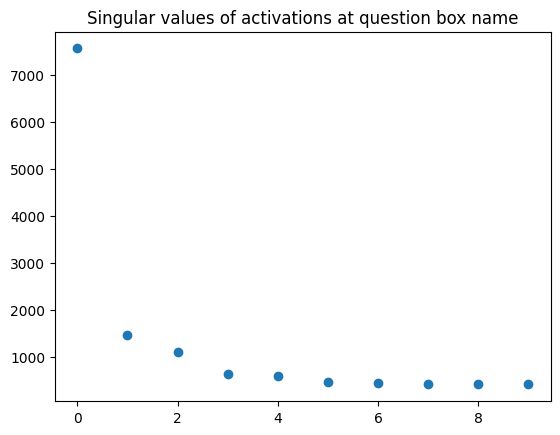

In [8]:
num_points = 10
plt.scatter(t.arange(num_points), S[:num_points])
plt.title("Singular values of activations at question box name")

In [9]:
pointer_D = V.T[0] # unit norm

might be a single direction! Are single encoded as an integer?

In [10]:
fname_dataset = '/share/u/can/by_reference/data/box_base_source_dataset.json'
with open(fname_dataset, 'r') as f:
    both_datasets = json.load(f)
base_dataset = both_datasets['base_dataset']
source_dataset = both_datasets['source_dataset']

In [20]:
layers = [12]
source_relation_orders = [int(source['question']['answer_key'][1:]) for source in source_dataset]
num_relations = len(set(source_relation_orders))
num_samples = len(source_dataset)
num_samples_per_relation = int(num_samples / num_relations)

act_LBRD = t.zeros((len(layers), num_relations, num_samples_per_relation, model._model.config.hidden_size))
for relation_idx in range(num_relations):
    mask = t.tensor(source_relation_orders) == relation_idx
    act_LBRD[:, relation_idx] = act_LBED[:, mask, -1, :]

act_LBRD.shape
act_BRD = act_LBRD[0, :, :, :]    # layer 12

Text(0.5, 0.98, 'Projection of residual activations on to singular vectors of activations at box name in the question')

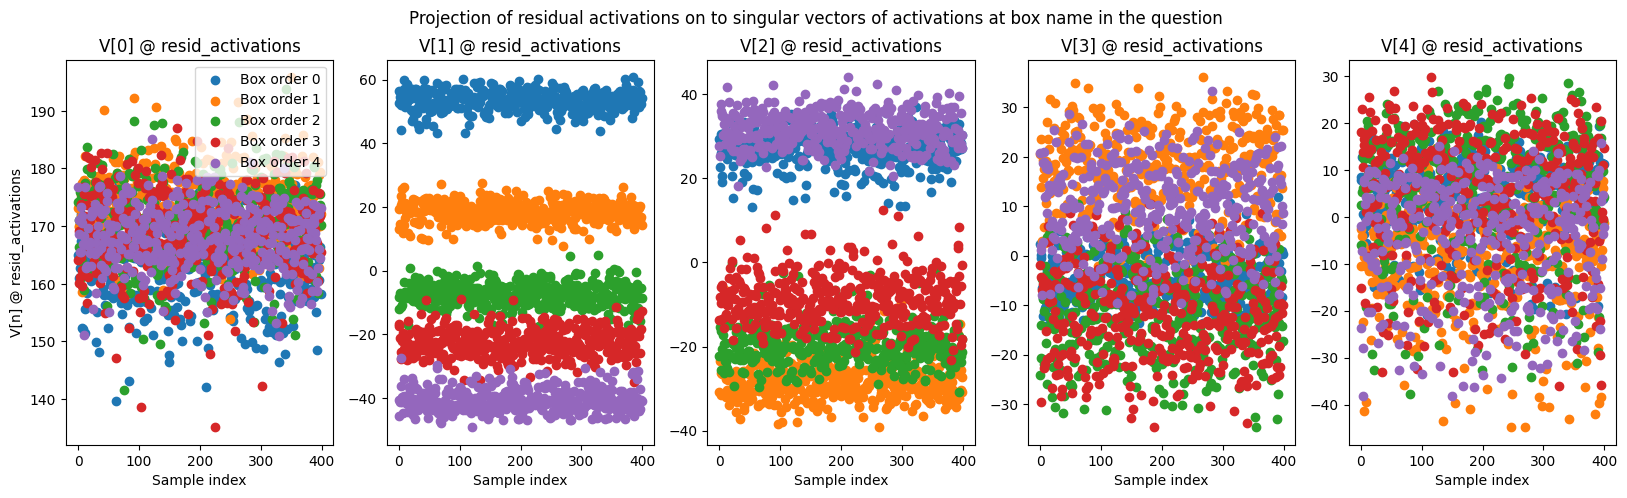

In [21]:
import matplotlib.pyplot as plt

num_vs = 5
fig, ax = plt.subplots(1, num_vs, figsize=(20, 5))

for v in range(num_vs):
    for i in range(num_relations):
        pointer_components = act_BRD[i] @ V.T[v]
        ax[v].scatter(t.arange(num_samples_per_relation), pointer_components)
        ax[v].set_title(f"V[{v}] @ resid_activations")
        ax[v].set_xlabel("Sample index")
        if v == 0:
            ax[v].legend([f"Box order {i}" for i in range(num_relations)], loc='upper right')
            ax[v].set_ylabel("V[n] @ resid_activations")


fig.suptitle("Projection of residual activations on to singular vectors of activations at box name in the question")